# LSTM for power forecasting

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [264]:
# read data
df = pd.read_csv('../../data/raw_pvdaq/pvdaq_2012_2014_15min.csv', header=0, infer_datetime_format=True, parse_dates=['Date-Time'], index_col=['Date-Time'])
df.head

<bound method NDFrame.head of                      SiteID  ac_current  ac_power  ac_voltage  ambient_temp  \
Date-Time                                                                     
2012-01-01 00:00:00    1277         0.0    -200.0       286.0      4.780557   
2012-01-01 00:15:00    1277         0.0    -100.0       285.0      4.628891   
2012-01-01 00:30:00    1277         0.0    -200.0       285.0      4.415002   
2012-01-01 00:45:00    1277         0.0    -100.0       286.0      3.925557   
2012-01-01 01:00:00    1277         0.0    -100.0       285.0      3.571113   
...                     ...         ...       ...         ...           ...   
2014-12-31 22:45:00    1277         0.0    -200.0       288.0      0.758890   
2014-12-31 23:00:00    1277         0.0    -100.0       288.0      0.471668   
2014-12-31 23:15:00    1277         0.0    -100.0       288.0      0.466113   
2014-12-31 23:30:00    1277         0.0    -100.0       288.0      0.320001   
2014-12-31 23:45:00   

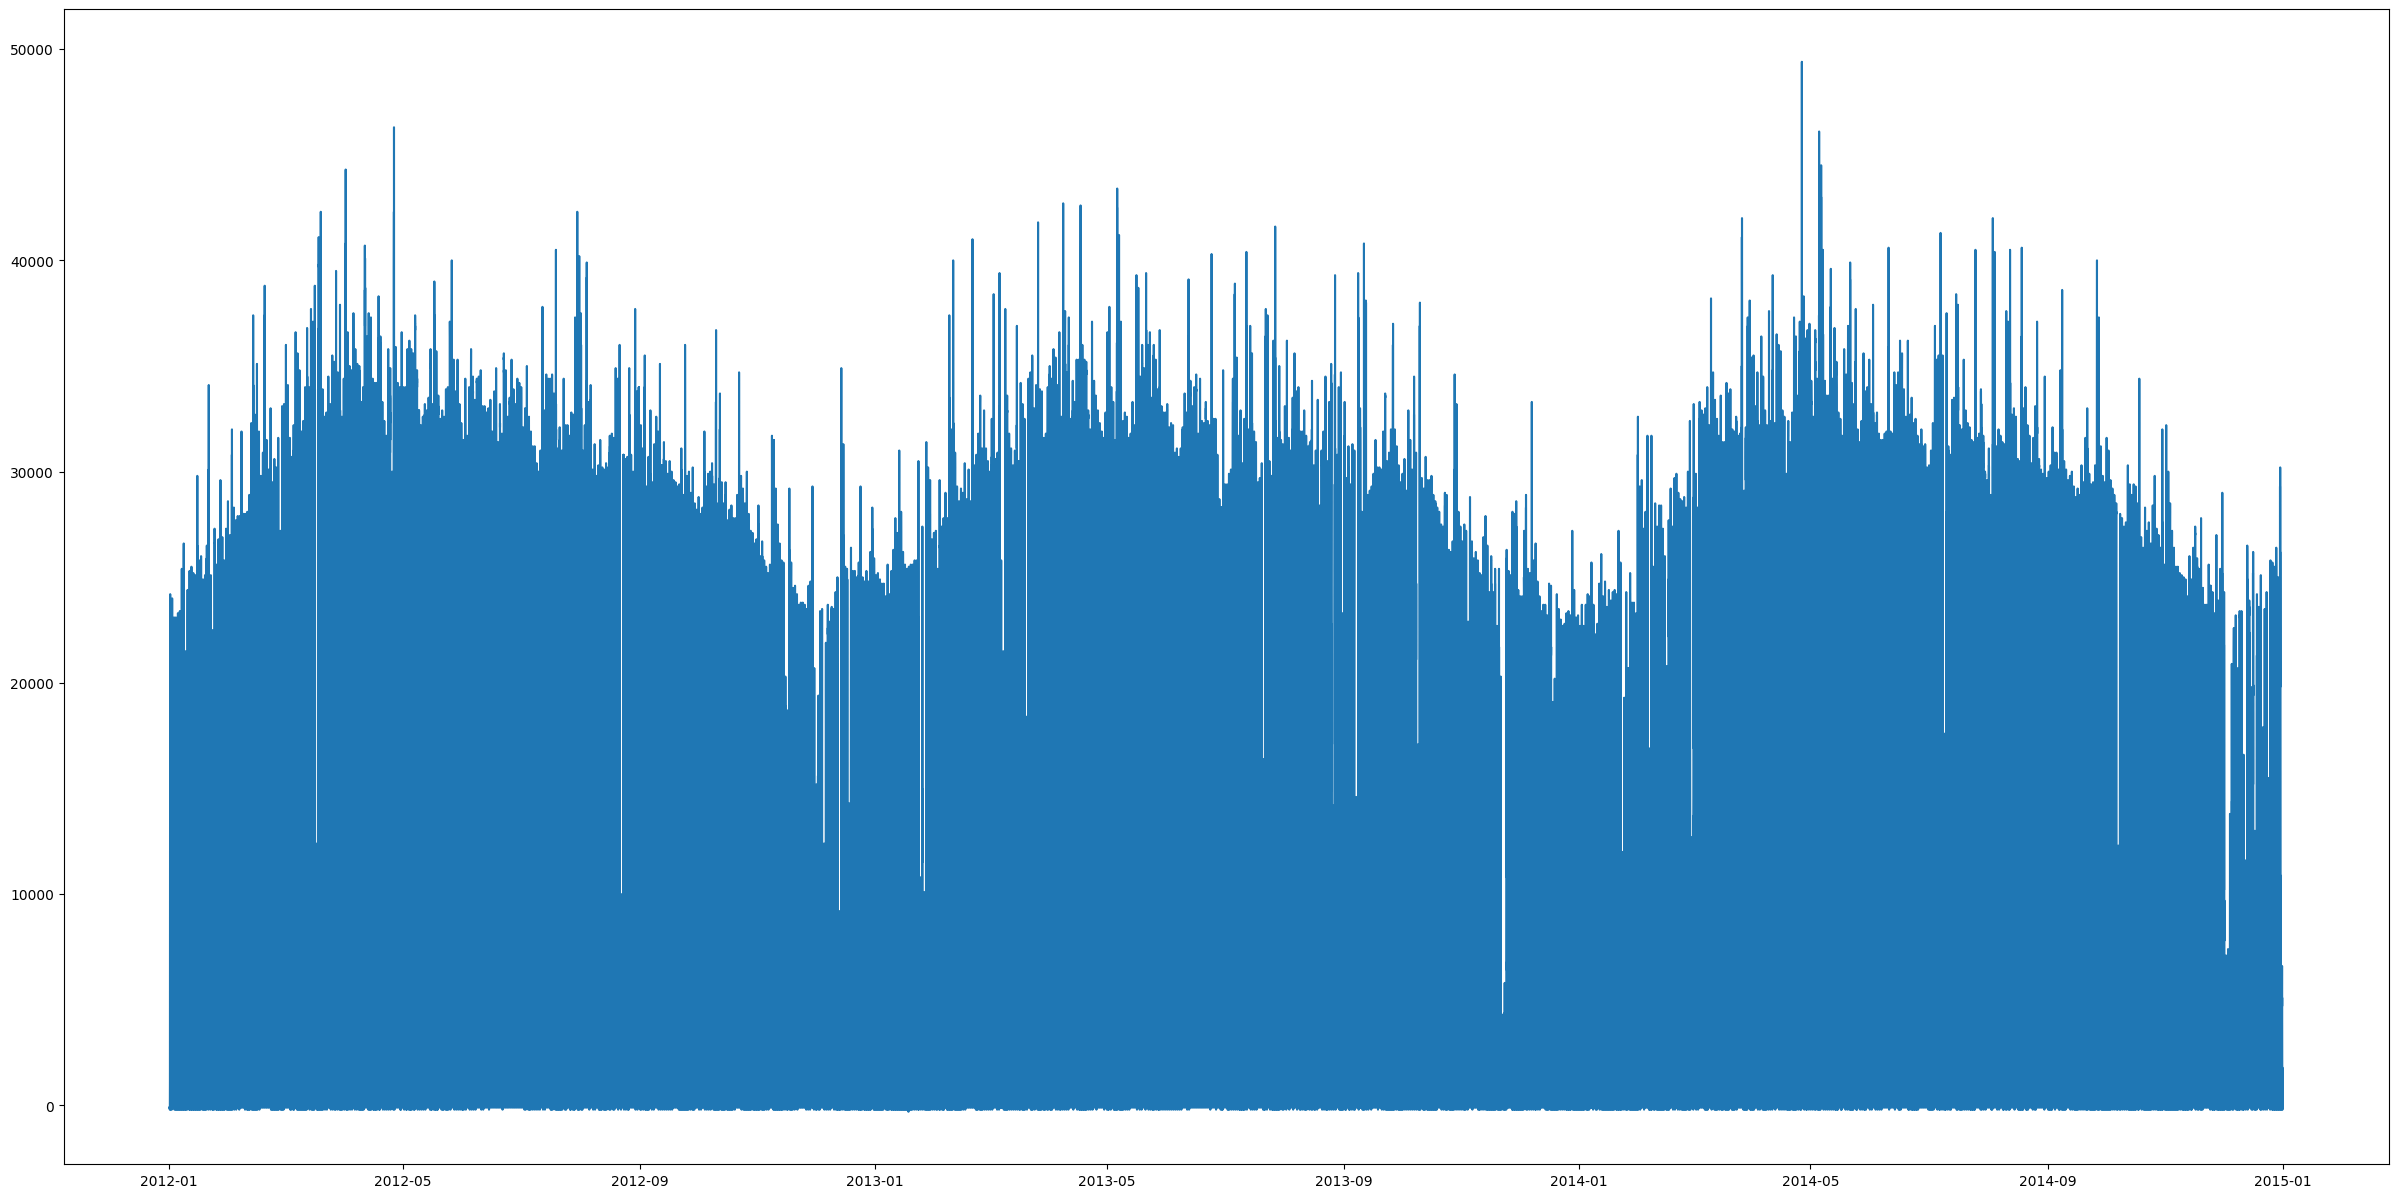

In [265]:
plt.figure(figsize=(30,15))
plt.plot(df.index,df['dc_power'])

In [266]:
features = ['ambient_temp', 'inverter_temp', 'module_temp', 'poa_irradiance', 'relative_humidity', 'wind_direction', 'wind_speed']
# features = ['ambient_temp', 'inverter_temp', 'module_temp', 'poa_irradiance']
target = ['dc_power']
time_indexes = [df.index.hour, df.index.month]
time_indexes

[Int64Index([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,
             ...
             21, 21, 22, 22, 22, 22, 23, 23, 23, 23],
            dtype='int64', name='Date-Time', length=105231),
 Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
             ...
             12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
            dtype='int64', name='Date-Time', length=105231)]

In [267]:
# feature columns stacking
data = []
for index in time_indexes:
  index_col = index.values.reshape(-1, 1)
  data.append(index_col)
for feature in features:
  feature_col = df[feature].values.reshape(-1, 1)
  data.append(feature_col)
data.append(np.maximum(df[target].values.reshape(-1,1),0))
data = np.hstack((data))

In [268]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [269]:
data = series_to_supervised(data, 0, 1)
data.shape

(105231, 10)

In [270]:
values = data.values
values = values.astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
print(values.shape)
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.shape

(105231, 10)


(105230, 20)

In [271]:
# drop columns that you dont want to predict
reframed.drop(reframed.columns[10:], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1)
1,0.000000,0.0,0.219596,0.241379,0.223856,0.0,0.423768,0.871443,0.091013,0.0
2,0.000000,0.0,0.217038,0.241379,0.212583,0.0,0.436813,0.871380,0.039990,0.0
3,0.000000,0.0,0.213431,0.224138,0.201827,0.0,0.452557,0.871380,0.042820,0.0
4,0.000000,0.0,0.205177,0.224138,0.200790,0.0,0.478145,0.871380,0.033838,0.0
5,0.043478,0.0,0.199200,0.224138,0.192756,0.0,0.483102,0.871443,0.049711,0.0


In [272]:
# n_data = np.size(data,0) # 26304
# n_feature = len(features) # 7
# index = data[:,n_feature:n_feature+2]
# X = data[:,0:n_feature]
# y = data[:,-1]
# X, y

In [273]:
# X_train, y_train, index_train = X[:-200,:], y[:-200], df.index[:-200]
# X_test, y_test, index_test = X[-200:,:], y[-200:], df.index[-200:]
# X_train.shape, y_train, y_test

In [274]:
# def create_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-look_back-1):
#         a = dataset[i:(i+look_back), 0]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)

In [275]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# data = scaler.fit_transform(data)
# train, test = data[0:-200,:], data[-200:-1,:]
# train.shape

In [276]:
# look_back = 1
# X_train, y_train = create_dataset(train, look_back)
# X_test, y_test = create_dataset(test, look_back)
# X_train.shape, y_train.shape

In [277]:
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))#（样本个数，1，输入的维度）
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
# X_train.shape

In [286]:
values = reframed.values
train = values[80000:-200, :]
test = values[-200:, :]
index_train = df.index[80000:-200]
index_test = df.index[-200:]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25030, 1, 9), (25030,), (200, 1, 9), (200,))

### Set up LSTM

Epoch 1/10
2503/2503 - 5s - loss: 0.0629 - val_loss: 0.0369 - 5s/epoch - 2ms/step
Epoch 2/10
2503/2503 - 4s - loss: 0.0503 - val_loss: 0.0323 - 4s/epoch - 2ms/step
Epoch 3/10
2503/2503 - 4s - loss: 0.0483 - val_loss: 0.0354 - 4s/epoch - 1ms/step
Epoch 4/10
2503/2503 - 4s - loss: 0.0480 - val_loss: 0.0312 - 4s/epoch - 1ms/step
Epoch 5/10
2503/2503 - 4s - loss: 0.0475 - val_loss: 0.0303 - 4s/epoch - 1ms/step
Epoch 6/10
2503/2503 - 4s - loss: 0.0471 - val_loss: 0.0302 - 4s/epoch - 1ms/step
Epoch 7/10
2503/2503 - 4s - loss: 0.0470 - val_loss: 0.0297 - 4s/epoch - 2ms/step
Epoch 8/10
2503/2503 - 4s - loss: 0.0466 - val_loss: 0.0296 - 4s/epoch - 2ms/step
Epoch 9/10
2503/2503 - 4s - loss: 0.0468 - val_loss: 0.0295 - 4s/epoch - 2ms/step
Epoch 10/10
2503/2503 - 4s - loss: 0.0463 - val_loss: 0.0291 - 4s/epoch - 2ms/step


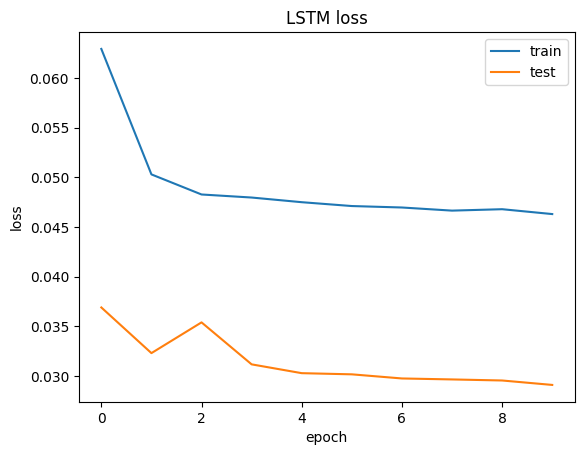

In [279]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=2, shuffle=False)
model.save("forecast_lstm_model.h5")

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [281]:
from tensorflow import keras
model = keras.models.load_model("forecast_lstm_model.h5")

y_pred = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[2]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, y_pred.shape

7/7 [==============================] - 0s 2ms/step


((25030, 9), (25030, 1), (200, 9), (200, 1), (200, 1))

In [283]:
# 反归一化
xy_pred = np.concatenate((X_test, y_pred), axis=1)
print(xy_pred.shape)
xy_pred_inv = scaler.inverse_transform(xy_pred)
y_pred_inv = xy_pred_inv[:,-1]

xy_test = np.concatenate((X_test, y_test), axis=1)
print(xy_test.shape)
xy_test_inv = scaler.inverse_transform(xy_test)
y_test_inv = xy_test_inv[:, -1]

xy_train = np.concatenate((X_train, y_train), axis=1)
print(xy_train.shape)
xy_train_inv = scaler.inverse_transform(xy_train)
y_train_inv = xy_train_inv[:, -1]

y_pred_inv.shape, y_test_inv.shape, y_train_inv.shape

(200, 10)
(200, 10)
(25030, 10)


((200,), (200,), (25030,))

In [284]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from math import sqrt
#回归评价指标
# calculate MSE 均方误差
mse = mean_squared_error(y_test_inv,y_pred_inv)
# calculate RMSE 均方根误差
rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
#calculate MAE 平均绝对误差
mae=mean_absolute_error(y_test_inv,y_pred_inv)
#calculate R square
r_square=r2_score(y_test_inv,y_pred_inv)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)
print('R_square: %.6f' % r_square)

均方误差: 11023439.523015
均方根误差: 3320.156551
平均绝对误差: 1436.902321
R_square: 0.686250


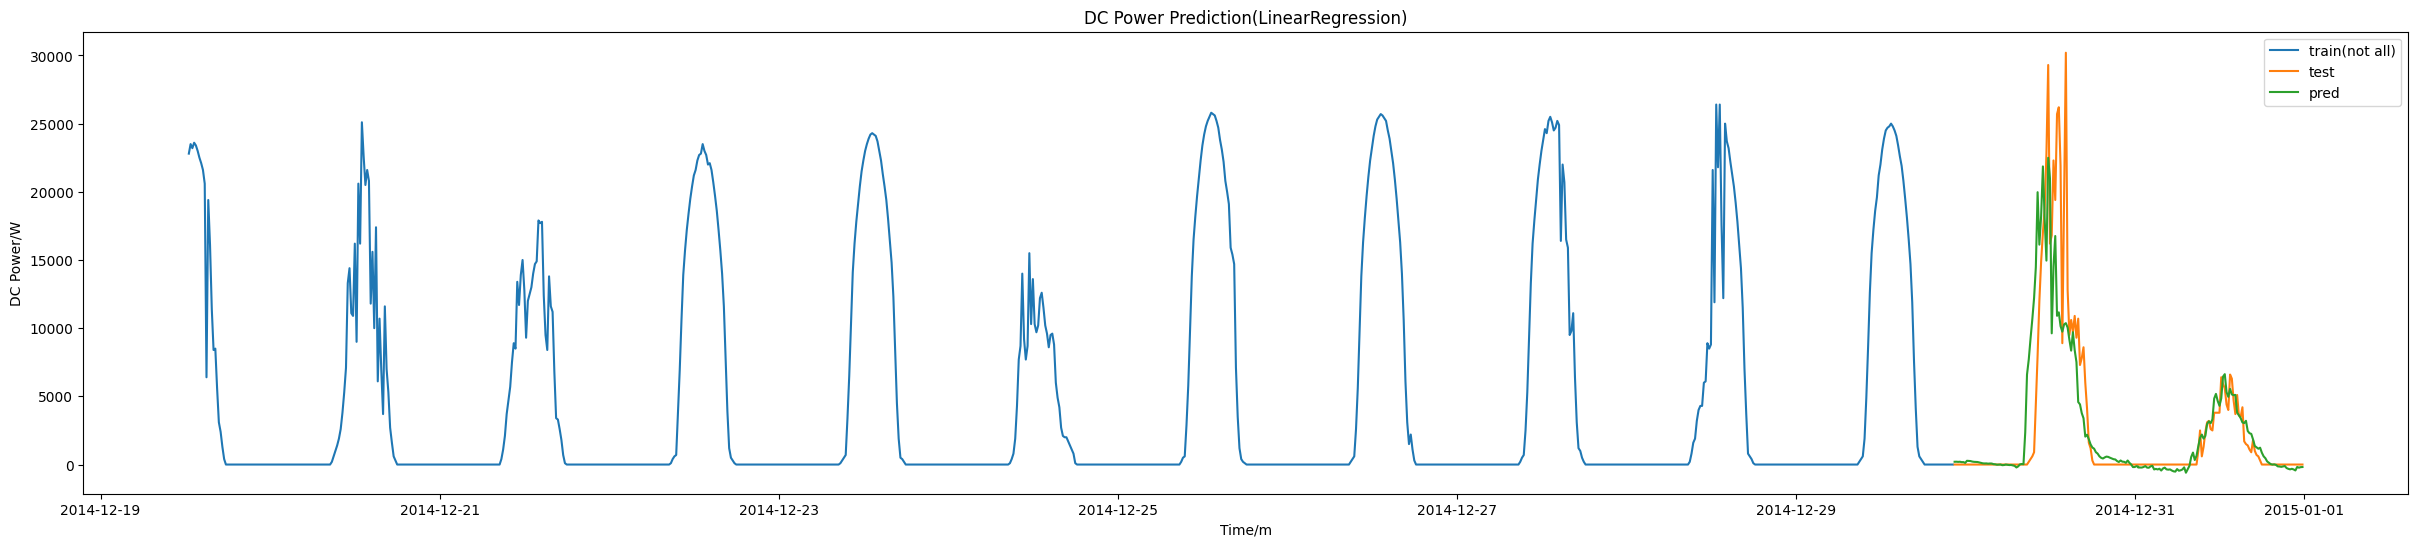

In [287]:
plt.figure(figsize=(30, 6))
plt.xlabel('Time/m')
plt.ylabel('DC Power/W')
plt.title("DC Power Prediction(LinearRegression)")
plt.plot(index_train[-1000:], y_train_inv[-1000:],label='train(not all)')
plt.plot(index_test, y_test_inv,label='test')
plt.plot(index_test, y_pred_inv,label='pred')
plt.legend()
# plt.savefig('../../figures/PV forecast/DC Power Prediction(LSTM).png')